# MT Data-conditioned VAE

In [241]:
# pip install tensorflow

In [242]:
%load_ext autoreload
%autoreload 2

import os
import time
import gc
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import scipy as sp
from scipy import interpolate
# import scipy.interpolate

from cgnn import cvae_mt64_updated as vae

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
run = 's4'
if not os.path.exists(run):
    os.makedirs(run)

# Set up survey

In [244]:
def import_file(file):
    with open(file, 'r') as f:
        reader = csv.reader(f)
        data = list(reader)
    line = np.array(data, dtype=float)
    cond = line[:,25:55]
    obs_xs = line[:,270:285]
    print(obs_xs.shape)
    obs_zs = -line[:,286:301]
    print(obs_zs.shape)
    obs_total = np.concatenate((obs_xs, obs_zs), axis=1)
    print(obs_total.shape)
    pred_zs = line[:,348:363]
    return line,cond, obs_total, pred_zs

In [245]:
line1,cond1, obs1, pred1 = import_file('Line1_Central-Copy1.csv')
line2,cond2, obs2, pred2 = import_file('Line2_Central-Copy1.csv')
line3,cond3, obs3, pred3 = import_file('Line3_Central-Copy1.csv')

print(obs1)

(16258, 15)
(16258, 15)
(16258, 30)
(3355, 15)
(3355, 15)
(3355, 30)
(17419, 15)
(17419, 15)
(17419, 30)
[[6.295087 5.203734 4.723107 ... 0.976215 0.582863 0.272842]
 [6.274186 5.188221 4.709166 ... 0.971868 0.579572 0.271219]
 [6.262685 5.180632 4.702812 ... 0.96766  0.576283 0.269532]
 ...
 [6.030007 5.631565 5.39819  ... 1.78922  1.159736 0.554354]
 [5.965578 5.573674 5.343903 ... 1.782502 1.155238 0.552165]
 [5.912551 5.526641 5.300363 ... 1.777644 1.151855 0.550477]]


In [246]:
print(len(cond1[:,0]))

16258


In [247]:
np.save('Line1_Central.npy', line1)
# np.save('Line1_Central_Conductivity.npy',cond1)
np.save('Line1_Central_Observations.npy',obs1)

In [248]:
np.save('Line2_Central.npy', line2)
# np.save('Line2_Central_Conductivity.npy',cond2)
np.save('Line2_Central_Observations.npy',obs2)

In [249]:
np.save('Line3_Central.npy', line3)
# np.save('Line3_Central_Conductivity.npy',cond3)
np.save('Line3_Central_Observations.npy',obs3)

In [250]:
data1 = np.load('Line1_Central.npy')
np.load('Line1_Central_Observations.npy')

array([[6.295087, 5.203734, 4.723107, ..., 0.976215, 0.582863, 0.272842],
       [6.274186, 5.188221, 4.709166, ..., 0.971868, 0.579572, 0.271219],
       [6.262685, 5.180632, 4.702812, ..., 0.96766 , 0.576283, 0.269532],
       ...,
       [6.030007, 5.631565, 5.39819 , ..., 1.78922 , 1.159736, 0.554354],
       [5.965578, 5.573674, 5.343903, ..., 1.782502, 1.155238, 0.552165],
       [5.912551, 5.526641, 5.300363, ..., 1.777644, 1.151855, 0.550477]])

In [251]:
data2 = np.load('Line2_Central.npy')
np.load('Line2_Central_Conductivity.npy')

array([[0.03648398, 0.04375333, 0.06125686, ..., 0.001001  , 0.00100172,
        0.00100138],
       [0.03692505, 0.04404815, 0.06117529, ..., 0.00100094, 0.00100167,
        0.00100133],
       [0.0355793 , 0.04299819, 0.06089889, ..., 0.00100111, 0.00100183,
        0.00100149],
       ...,
       [0.00886633, 0.01143951, 0.02004766, ..., 0.00100052, 0.00100119,
        0.00100088],
       [0.00974181, 0.01277133, 0.02308966, ..., 0.0010005 , 0.00100116,
        0.00100085],
       [0.01089706, 0.01448192, 0.02690818, ..., 0.00100052, 0.00100117,
        0.00100087]])

In [252]:
data3 = np.load('Line3_Central.npy')
np.load('Line3_Central_Conductivity.npy')

array([[0.04755097, 0.07919228, 0.2120686 , ..., 0.00100109, 0.00100129,
        0.0010012 ],
       [0.0492395 , 0.08198991, 0.2180947 , ..., 0.00100109, 0.00100129,
        0.00100119],
       [0.05325513, 0.08775873, 0.2287608 , ..., 0.00100107, 0.00100127,
        0.00100118],
       ...,
       [0.013676  , 0.01695183, 0.02671344, ..., 0.00100166, 0.00100244,
        0.00100208],
       [0.01278256, 0.01582356, 0.02485566, ..., 0.00100166, 0.00100244,
        0.00100208],
       [0.01163806, 0.01427949, 0.02214111, ..., 0.00100167, 0.00100249,
        0.0010021 ]])

In [253]:
print(len(cond1[0]))

30


In [254]:
# remote reference frequencies
#   7.680002e+02   5.120000e+02   3.840000e+02   2.560000e+02   1.920000e+02   1.280000e+02
#   9.599997e+01   6.400000e+01   4.800001e+01   3.200000e+01   2.400000e+01   1.600000e+01
#   1.200000e+01   8.000000e+00   5.999999e+00   4.000000e+00   3.000000e+00   2.000000e+00
#   1.500000e+00   1.000000e+00   7.500002e-01   5.000000e-01   3.750000e-01   2.500000e-01
#   1.875000e-01


# mesh
# 64 ft
cell_size = 32*0.3048
depth_to_top = 32*0.3048
n_cells = 32
# one fewer depth; last cell extends to inf
#depths = depth_to_top + np.arange(1,n_cells)*cell_size
#depths to bottom
depths = np.array([4,8.4,13.24,18.56,24.42,30.86,37.95,45.74,54.31,63.74,74.11,85.52,98.07,111.88,127.07,143.78,162.16,182.38,204.62,229.08,255.99,285.59,318.15,353.97,393.37,436.71,484.38,536.82,594.5])
n_depths = len(depths)
print(n_depths)
# data frequencies
# conservative, lines up with remote referenced stations, minus one frequency to avoid extrapolation
f_a = np.logspace(-2, 9, num=12, base=2)
f_b = np.logspace(-4, 7, num=12, base=2)*3
times = np.array([0.013,0.039,0.065,0.104,0.169,0.273,0.443,0.703,1.094,1.693,2.63,4.102,6.406,9.961,16.055])
# frequencies = np.logspace(-4, 10, 15, base=2)
nt = len(times)
print(nt)
# data are only real
ndata = nt

29
15


In [255]:
depth = np.append(0,depths)
# print(depth)
cond1_new = np.zeros((len(cond1[:,0]),32))
for i in range(len(cond1[:,0])):
    x = cond1[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    cond1_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

cond2_new = np.zeros((len(cond2[:,0]),32))
for i in range(len(cond2[:,0])):
    x = cond2[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    cond2_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

cond3_new = np.zeros((len(cond3[:,0]),32))
for i in range(len(cond3[:,0])):
    x = cond3[i]
    y = depth
    f = sp.interpolate.interp1d(y,x)
    y_new = [554,573]
    x_new = f(y_new)
    cond3_new[i] = np.append(x,x_new)
    y = np.append(y_new,depths)
    y.sort()

# print(len(cond1_new[0]))
# print(cond1_new[1])
depths=y
print(depths)


[  4.     8.4   13.24  18.56  24.42  30.86  37.95  45.74  54.31  63.74
  74.11  85.52  98.07 111.88 127.07 143.78 162.16 182.38 204.62 229.08
 255.99 285.59 318.15 353.97 393.37 436.71 484.38 536.82 554.   573.
 594.5 ]


In [256]:
np.save('Line1_Central_Conductivity.npy',cond1_new)
np.save('Line2_Central_Conductivity.npy',cond2_new)
np.save('Line3_Central_Conductivity.npy',cond3_new)

In [257]:
# x = np.arange(depths.size)
# new_length = 63
# new_x = np.linspace(x.min(), x.max(), new_length)
# new_depths = sp.interpolate.interp1d(x, depths)(new_x)
# print(new_depths)
# print(len(new_depths))
# depths = new_depths

# Load training models and Create neural network

In [266]:
# normalize model parameters between -1 and 1
# remember, min resistivity is 0.01, max is 1e5
# Gaussian infill potentially allows for values outside this range, but not likely
min_model = np.log(1e-5)
max_model = np.log(1e5)
# pad by norm_pad, so that a bunch of values don't end up at -1
norm_pad = 0.1

# create network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times = times,
                   norm_pad=norm_pad,
#                    data_std=0.1,
#                    model_std=.01,
                   beta_vae=1,
                   model_loss_type='ae',
                   data_loss_type='se'
                  )

(31,)


In [259]:
# Due to ranging orders of magnitude - recommended to keep
def preprocess(filename):
    '''
    Read RILD values from npy file
    Convert to log conductivity
    Reshape to include channel dimension
    '''
    x = np.log(1/np.load(filename))
    x = x.reshape(-1, n_cells, 1)
    return x

def preprocess_obs(filename):
    '''
    Read RILD values from npy file
    Convert to log conductivity
    Reshape to include channel dimension
    '''
    x = np.log(1/np.load(filename))
    x = x.reshape(-1, 30, 1)
    return x

x_train_log = preprocess('Line1_Central_Conductivity.npy')
x_validate_log = preprocess('Line3_Central_Conductivity.npy')
x_test1_log = preprocess('Line2_Central_Conductivity.npy')
# x_test2_log = preprocess('KGS_RILD_64ft_test2.npy')
# print(x_train_log)

x_train_raw_log = preprocess_obs('Line1_Central_Observations.npy')
x_validate_raw_log = preprocess_obs('Line3_Central_Observations.npy')
x_test1_raw_log = preprocess_obs('Line2_Central_Observations.npy')
#print(x_train_raw_log)

x_train_raw = network.model_to_tanhs(x_train_raw_log)
x_validate_raw = network.model_to_tanhs(x_validate_raw_log)
x_test1_raw = network.model_to_tanhs(x_test1_raw_log)
# print(x_train_raw)

x_train = network.model_to_tanhs(x_train_log)
x_validate = network.model_to_tanhs(x_validate_log)
x_test1 = network.model_to_tanhs(x_test1_log)
# x_test2 = network.model_to_tanhs(x_test2_log)
print(x_train)
print(np.max(x_train))

[[[ 0.3717506 ]
  [ 0.35877268]
  [ 0.33019401]
  ...
  [ 0.5399025 ]
  [ 0.53984124]
  [ 0.53986997]]

 [[ 0.35924058]
  [ 0.3459848 ]
  [ 0.3168738 ]
  ...
  [ 0.53991749]
  [ 0.53985802]
  [ 0.53988592]]

 [[ 0.34984667]
  [ 0.33582953]
  [ 0.30524038]
  ...
  [ 0.53992124]
  [ 0.53986095]
  [ 0.53988923]]

 ...

 [[-0.06332845]
  [-0.10986223]
  [-0.13967353]
  ...
  [ 0.53997866]
  [ 0.53995864]
  [ 0.53996803]]

 [[-0.06540916]
  [-0.10690175]
  [-0.13454177]
  ...
  [ 0.53997788]
  [ 0.53995752]
  [ 0.53996707]]

 [[-0.0760605 ]
  [-0.10976947]
  [-0.12975373]
  ...
  [ 0.53997772]
  [ 0.5399577 ]
  [ 0.53996709]]]
0.5400728129689761


In [260]:
x_train1 = x_train[0:100,]
x_validate1 = x_validate[0:100,]
x_train_raw1 = x_train_raw[0:100,]
x_validate_raw1 = x_validate_raw[0:100,]
x_test_raw1 = x_test1_raw[0:100,]
print(x_train1.T[0,].shape)

(32, 100)


In [271]:
# compute stds
model_std = np.std(x_train.flatten())
#mt_data_file = 'KGS_MT.npy'
#os.remove(mt_data_file)
#try:
#    all_data = tf.convert_to_tensor(np.load(mt_data_file))
#except FileNotFoundError:
#    all_data = network.predict_tanh(x_train)
#    np.save(mt_data_file, all_data.numpy())
train_data = network.predict_tanh(x_train1)
# print(train_data)
print("train data", train_data)
print('.........')
raw_train_data = network.predict_tanh(x_train_raw1)
# log_train_data = tf.math.log(-train_data)
#print('log_train_data'log_train_data.shape)
print("raw_train_data", raw_train_data)

validate_data = network.predict_tanh(x_validate1)
raw_validate_data = network.predict_tanh(x_validate_raw1)

# test1_data = network.predict_tanh(x_test1)
# log_test1_data = tf.math.log(-test1_data)

# test2_data = network.predict_tanh(x_test2)
# log_test2_data = tf.math.log(-test2_data)

tanhs (100, 32, 1)
Zss (100, 32)
xn (100, 32)


ValueError: could not broadcast input array from shape (30,) into shape (32,)

In [ ]:
# np.save('train_data.npy',train_data)
# np.save('raw_train_data.npy',raw_train_data)
# np.save('validate_data.npy',validate_data)
# np.save('raw_validate_data.npy',raw_validate_data)

In [ ]:
# train_data = np.load('train_data.npy')
# raw_train_data = np.load('raw_train_data.npy')
# validate_data = np.load('validate_data.npy')
# raw_validate_data = np.load('raw_validate_data.npy')

In [ ]:
# # Create batches and shuffle
BATCH_SIZE = 75

#x_train1 = models *log transform models*; log_train_data: raw data

train_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_train1, tf.float32), 
    tf.cast(raw_train_data, tf.float32))).shuffle(10000).batch(BATCH_SIZE)

validate_dataset = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_validate1, tf.float32),
    tf.cast(raw_validate_data, tf.float32))).shuffle(10000).batch(x_validate1.shape[0])

# though the data vary over several orders of magnitude, 
# they don't vary so much within one frequency.
# data_std_vec = np.std(train_data.numpy(), axis=0)
# log_data_std_vec = np.std(log_train_data.numpy(), axis=0)
# log_data_std = np.std(log_train_data.numpy().flatten())
# average_log_data_std = np.std((log_train_data.numpy() - log_train_data.numpy().mean(axis=0)).flatten())
# print(model_std, log_data_std, average_log_data_std)
# compute elementwise stds
model_std_vec = np.std(x_train1, axis=0)
model_std_vec = np.reshape(model_std_vec, (n_cells))
# # compute relative std
mean_train_data = np.mean(train_data, axis=0)
rel_data_std = np.abs(mean_train_data)

# same for model, but mean over all
mean_model_value = np.mean(x_train1)
rel_model_std = 0.5*mean_model_value
print(mean_model_value, rel_model_std)

0.3091059569838888 0.1545529784919444


In [ ]:
# finalize network
network = vae.CVAE(depths,
                   min_model=min_model,
                   max_model=max_model,
                   times=times,
                   norm_pad=norm_pad,
                   data_std=rel_data_std.reshape(1, -1, 1),
#                    model_std=model_std,
                   model_std=model_std_vec.reshape(1, -1, 1),
                   latent_dim=20,
                   beta_vae=1,
                   model_loss_type='se',
                   data_loss_type='se'
                  )

# double check forward model
'''

all_data[0, 0], all_data[0, 24]

network.predict_tanh(x_train[0:1])

c60 = np.load('KSG_RILD_60ft.npy')
c60[0].shape

vae.forward_1_freq(c60[200], depths, frequencies[0])[0]

vae.forward_1_freq(c60[200], depths, frequencies[-1])[0]

all_data.numpy().max(), all_data.numpy().min()

all_data.shape

'''

#for i_freq in range(nf):
#    plt.hist(all_data.numpy()[:, i_freq].flatten(), bins=50)

c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


"\n\nall_data[0, 0], all_data[0, 24]\n\nnetwork.predict_tanh(x_train[0:1])\n\nc60 = np.load('KSG_RILD_60ft.npy')\nc60[0].shape\n\nvae.forward_1_freq(c60[200], depths, frequencies[0])[0]\n\nvae.forward_1_freq(c60[200], depths, frequencies[-1])[0]\n\nall_data.numpy().max(), all_data.numpy().min()\n\nall_data.shape\n\n"

In [ ]:
# May be able to remove/adjust steps since I have data instead of models
i_random_train = np.arange(16)
# random_train = x_train[i_random_train].reshape((16, n_cells))
# pick some random training models
# i_random_train = np.random.randint(0, x_train1.shape[0], 16)
#i_random_train = np.arange(16)
random_train = x_train1[i_random_train].reshape((16, n_cells))
print('i_random_train',i_random_train)
print('random_train',random_train)
# predict their data
random_data = network.predict_tanh(random_train.reshape(16, n_cells, 1))
print('n_cells',n_cells)
random_log_data = tf.math.log(-random_data)
print('random_log_data', random_log_data)
print('random_data',random_data)
# Save data and latent space inputs for plots
# print(network.latent_dim)
latent_input = tf.random.normal([16, network.latent_dim], seed=0, dtype=tf.float32)
# print(latent_input)
print('n_data',network.n_data)
data_input = tf.reshape(random_data,(16,network.n_data))
print('data_input',data_input)
zd_input = tf.concat((latent_input,data_input),axis=-1)
print('zd_input',zd_input)
# Why are there nan values????? The forward modelling produces (16,30) arrays which should fit perfectly into data_input
#

i_random_train [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
random_train [[ 3.71750602e-01  3.58772676e-01  3.30194010e-01  2.82490024e-01
   2.12936612e-01  1.27888156e-01  6.02049786e-02  3.49576498e-02
   4.40362114e-02  6.53828532e-02  7.59341185e-02  6.06357791e-02
   1.76675995e-02  4.19611529e-03  7.98784278e-02  1.83823370e-01
   2.79550958e-01  3.57563413e-01  4.17262398e-01  4.60768152e-01
   4.91039839e-01  5.11126956e-01  5.23797698e-01  5.31371287e-01
   5.35645945e-01  5.37917092e-01  5.39050902e-01  5.39582423e-01
   5.39815261e-01  5.39902501e-01  5.39841235e-01  5.39869971e-01]
 [ 3.59240576e-01  3.45984796e-01  3.16873801e-01  2.68490179e-01
   1.98700643e-01  1.15832258e-01  5.35029192e-02  3.38021340e-02
   4.67337210e-02  6.72045859e-02  7.43442646e-02  5.62247407e-02
   1.44325321e-02  7.50414536e-03  8.70015047e-02  1.90955564e-01
   2.85389842e-01  3.61932776e-01  4.20348794e-01  4.62848687e-01
   4.92383918e-01  5.11960888e-01  5.24296035e-01  5.31659321e-

ValueError: Model of len(32) incorrect shape for mappings: 
    sigmaMap: expected model of len(30) for IdentityMap(30,30)

In [ ]:
# plot a few random training models and their data
# vae.plot_complex(random_data, times=times, save2file=True, filename=run+'/training_MT_data.png')
vae.plot_logs(np.exp(network.tanhs_to_model(random_train)), depths=depths, save2file=True, 
              filename=run + '/training_models.png')

# Save starting plots
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                    latent=zd_input,step=0)
# network.plot_data(save2file=True,folder=run,latent=zd_input,step=0)
# network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=0)

plt.close('all')
plt.clf()
gc.collect()

22180

<Figure size 640x480 with 0 Axes>

In [ ]:
optimizer = tf.keras.optimizers.Adam(0.0002, 0.5)

# Train

In [ ]:
epochs = 10

In [ ]:
validate_terms = []
train_terms = []
train_losses = []
ttest_losses = []
# print(len(train_dataset))
for epoch in range(1, epochs + 1):
    start_time = time.time()
#     print(train_dataset)
#     print(optimizer)
    for train_x in train_dataset:#.batch(BATCH_SIZE):
        # print(len(train_x[1]))
        if len(train_x[1]) == 80:
            train_loss, train_term = vae.compute_apply_gradients(network, train_x, optimizer, 
                                    use_data_misfit=True)
        #train_losses.append(train_loss.numpy())
            train_terms.append([tt.numpy() for tt in train_term])
        else:
            continue
#         for test_x in test_dataset:
#             ttest_loss = vae.compute_losses(network, test_x)
#             terms = [loss(l).numpy() for l in ttest_loss]
#             ttest_losses.append(terms)
    end_time = time.time()

    # compute and save losses
    for val_x in validate_dataset:#.batch(BATCH_SIZE):
        val_loss, val_term = vae.compute_loss(network, val_x)
        #terms = [tf.reduce_mean(l).numpy() for l in losses]
        #loss(vae.compute_reconstruction_loss(network, test_x))
    #elbo = -loss.result()
    validate_terms.append([tt.numpy() for tt in val_term])
    print('Epoch: {}, Data misfit: {:.4}, '
          'Reconstruction: {:.4}, '
          'KL: {:.4}, '
          'Elapsed {:.4} s'.format(epoch, val_term[0], val_term[1], val_term[2],
                                #elbo,
                                end_time - start_time))
        
    if epoch % 1e3 == 0:
        network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
                 latent=zd_input,step=epoch)
        network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)
        network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch)
        plt.close('all')
        gc.collect()

network.inference_net.save(run+'/encoder.h5')
network.generative_net.save(run+'/decoder.h5')
#np.save(run+'/optimizer_weights.npy', optimizer.load_weights())
np.save(run+'/losses.npy', np.array(validate_terms))
np.save(run+'/train_losses.npy', np.array(train_terms))
# WHERE IS THE 35 COMING FROM????n

d_input: Tensor("xy_1:0", shape=(100, 30), dtype=float32)
zd: Tensor("concat:0", shape=(100, 50), dtype=float32)
tanhs (100, 32, 1)
ys <unknown>
ys_test <unknown>


InvalidArgumentError: Graph execution error:

Detected at node PyFunc defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\asyncio\windows_events.py", line 321, in run_forever

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\asyncio\base_events.py", line 608, in run_forever

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\asyncio\events.py", line 84, in _run

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\ipykernel\kernelbase.py", line 534, in dispatch_queue

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\ipykernel\kernelbase.py", line 523, in process_one

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\ipykernel\kernelbase.py", line 429, in dispatch_shell

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\ipykernel\kernelbase.py", line 767, in execute_request

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\ipykernel\ipkernel.py", line 429, in do_execute

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\IPython\core\interactiveshell.py", line 3051, in run_cell

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\IPython\core\interactiveshell.py", line 3106, in _run_cell

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\IPython\core\interactiveshell.py", line 3311, in run_cell_async

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\IPython\core\interactiveshell.py", line 3493, in run_ast_nodes

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code

  File "C:\Users\saraf\AppData\Local\Temp\ipykernel_17868\3222753852.py", line 27, in <module>

  File "c:\Users\saraf\OneDrive\Documents\EM-CVAE-Graduate_Research\cgnn\cvae_mt64_updated.py", line 639, in compute_loss

  File "c:\Users\saraf\OneDrive\Documents\EM-CVAE-Graduate_Research\cgnn\cvae_mt64_updated.py", line 400, in predict_tanh

  File "c:\Users\saraf\OneDrive\Documents\EM-CVAE-Graduate_Research\cgnn\cvae_mt64_updated.py", line 369, in predict_data

ValueError: Model of len(32) incorrect shape for mappings: 
    sigmaMap: expected model of len(30) for IdentityMap(30,30)
Traceback (most recent call last):

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\tensorflow\python\ops\script_ops.py", line 270, in __call__
    ret = func(*args)
          ^^^^^^^^^^^

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\tensorflow\python\autograph\impl\api.py", line 643, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\saraf\OneDrive\Documents\EM-CVAE-Graduate_Research\cgnn\cvae_mt64_updated.py", line 295, in forward_np
    Zss[ic, :] = forward_vec_freq(self.simulation, c)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

  File "c:\Users\saraf\OneDrive\Documents\EM-CVAE-Graduate_Research\cgnn\mt1d_updated.py", line 59, in forward_vec_freq
    dpred_conductive = EM.dpred(con)
                       ^^^^^^^^^^^^^

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\SimPEG\electromagnetics\time_domain\simulation_1d.py", line 211, in dpred
    f = self.fields(m)
        ^^^^^^^^^^^^^^

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\SimPEG\electromagnetics\time_domain\simulation_1d.py", line 223, in fields
    self.model = m
    ^^^^^^^^^^

  File "c:\Users\saraf\anaconda3\envs\simpeg\Lib\site-packages\SimPEG\props.py", line 421, in model
    raise ValueError(

ValueError: Model of len(32) incorrect shape for mappings: 
    sigmaMap: expected model of len(30) for IdentityMap(30,30)


	 [[{{node PyFunc}}]] [Op:__inference_compute_loss_9512]

In [ ]:
network.plot_models(save2file=True,folder=run,samples=zd_input.shape[0],
         latent=zd_input,step=epoch)

In [ ]:
network.plot_data(save2file=True,folder=run,latent=zd_input,step=epoch)

d_obs tf.Tensor(
[[-8.14143631e-12 -4.45883478e-12 -2.21306935e-12 -8.40448425e-13
  -2.44495206e-13 -5.23489604e-14 -9.47507318e-15 -1.73424840e-15
  -3.99860379e-16 -1.21620101e-16 -4.26845313e-17 -1.58558595e-17
  -6.08702154e-18 -2.17374462e-18]
 [-9.95676892e-12 -5.19682995e-12 -2.36698291e-12 -8.11656677e-13
  -2.11847182e-13 -4.08528531e-14 -6.98433426e-15 -1.34557367e-15
  -3.50895574e-16 -1.15315026e-16 -4.17375816e-17 -1.57209646e-17
  -6.07960173e-18 -2.18059575e-18]
 [-1.17951048e-11 -5.81258782e-12 -2.45157085e-12 -7.69135732e-13
  -1.83161537e-13 -3.25696670e-14 -5.44478708e-15 -1.13031211e-15
  -3.23866383e-16 -1.11385481e-16 -4.10578310e-17 -1.56025123e-17
  -6.06290509e-18 -2.18091400e-18]
 [-1.41891845e-11 -6.45129566e-12 -2.47851110e-12 -6.99946069e-13
  -1.50138799e-13 -2.46543644e-14 -4.17872354e-15 -9.71344773e-16
  -3.04714226e-16 -1.08820705e-16 -4.07594504e-17 -1.56158680e-17
  -6.09497446e-18 -2.19797647e-18]
 [-1.63179765e-11 -6.90042771e-12 -2.45082210e-12 -

In [ ]:
# something weird here
network.plot_residuals(save2file=True,folder=run,latent=zd_input,step=epoch,weighted=False)

tanhs (16, 32, 1)
ys (16, 30)
ys_test (16,)
n_data 30
d_obs tf.Tensor(
[[ 3.74183063e-12 -4.44009385e-13 -2.91814506e-13 -1.68612723e-13
  -7.81583457e-14 -2.92452762e-14 -8.83298578e-15 -2.62603825e-15
  -9.59332046e-16 -4.56272879e-16 -2.51044022e-16 -1.44984803e-16
  -8.49937211e-17 -5.00022541e-17 -2.77603898e-17 -6.23714899e-11
   8.14143631e-12  4.45883478e-12  2.21306935e-12  8.40448425e-13
   2.44495206e-13  5.23489604e-14  9.47507318e-15  1.73424840e-15
   3.99860379e-16  1.21620101e-16  4.26845313e-17  1.58558595e-17
   6.08702154e-18  2.17374462e-18]
 [ 3.67858348e-12 -4.83344051e-13 -2.99286583e-13 -1.61215713e-13
  -6.87843540e-14 -2.37086623e-14 -6.79091344e-15 -2.08518315e-15
  -8.44333983e-16 -4.33606515e-16 -2.46281632e-16 -1.44074349e-16
  -8.49954880e-17 -5.01729213e-17 -2.79090309e-17 -6.80868834e-11
   9.95676892e-12  5.19682995e-12  2.36698291e-12  8.11656677e-13
   2.11847182e-13  4.08528531e-14  6.98433426e-15  1.34557367e-15
   3.50895574e-16  1.15315026e-16  4

In [ ]:
plt.close('all')
plt.clf()
gc.collect()

22721

<Figure size 640x480 with 0 Axes>

# Load networks

In [ ]:
network.inference_net = tf.keras.models.load_model(run+'/encoder.h5')
network.generative_net = tf.keras.models.load_model(run+'/decoder.h5')

In [ ]:
loss_terms = np.load(run+'/losses.npy')

In [ ]:
#optimizer_weights = np.load(run+'/optimizer_weights.npy', allow_pickle=True)

https://stackoverflow.com/questions/49503748/save-and-load-model-optimizer-state to train more

# Plot loss over epochs

In [ ]:
plt.rcParams.update({'font.size': 18})

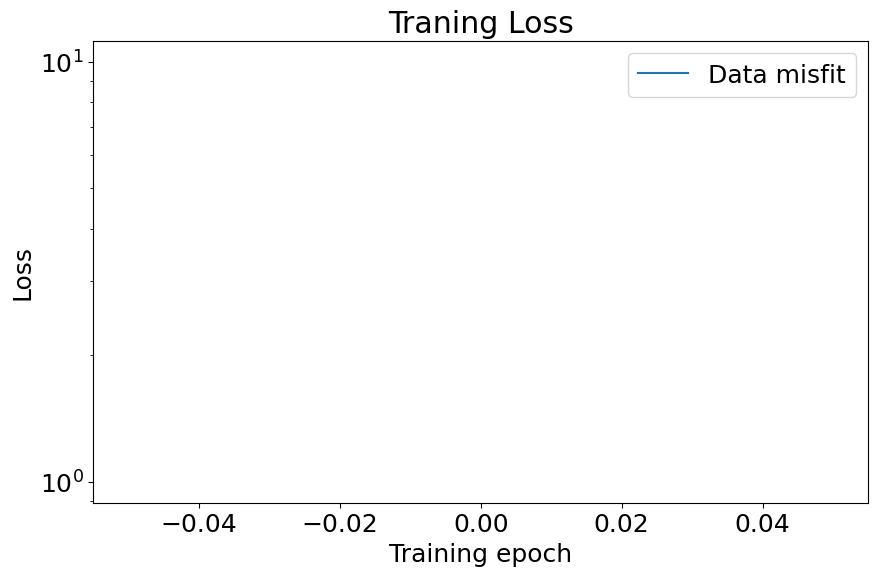

In [ ]:
tt = np.array(train_terms)
batches_per_epoch = tf.data.experimental.cardinality(train_dataset).numpy()
num_batches = tt.shape[0]
plt.figure(figsize=(10,6))
plt.semilogy(np.arange(num_batches)/batches_per_epoch, tt)
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title("Traning Loss")
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('training_loss_'+run+'_w.png')
plt.show()

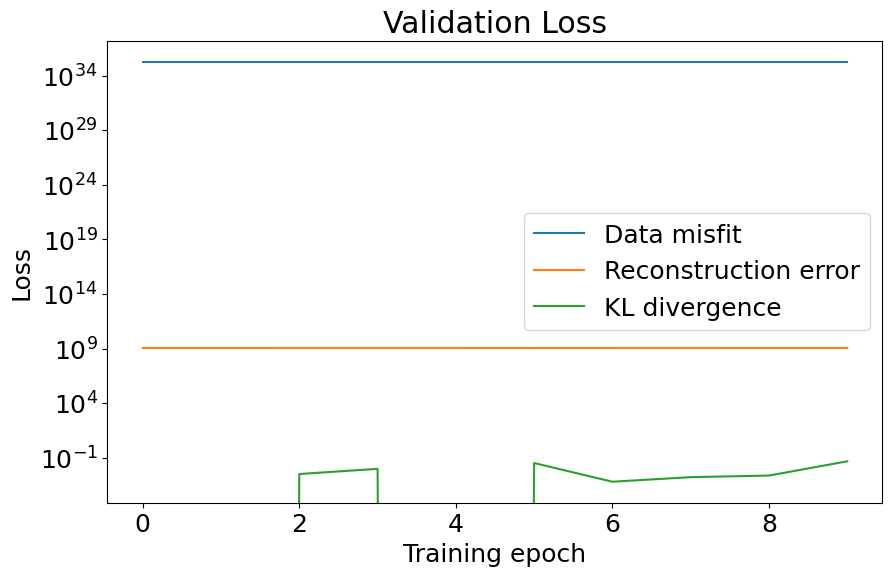

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(epochs),validate_terms)
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Training epoch')
plt.title('Validation Loss')
plt.legend(['Data misfit', 'Reconstruction error', 'KL divergence'])
plt.savefig('validation_loss_'+run+'_w.png')
plt.show()

# View some tests

In [ ]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_validate[0:16])), depths=depths, step=16, save2file=True)

In [ ]:
z_model = network.reparameterize(*network.encode(x_validate[0:16]))
z_data = raw_validate_data[0:16]
zmd = tf.concat((z_model,z_data),-1)
print(zmd)
network.plot_models(latent=zmd)

tf.Tensor(
[[-9.87157702e-01 -2.21571863e-01 -1.20503530e-01 -1.06825686e+00
  -1.03443921e+00 -4.23231006e-01  1.29319167e+00  1.42965302e-01
  -7.72000194e-01  1.42311668e+00  2.48320311e-01 -1.28284022e-01
  -1.13558519e+00  4.31705385e-01 -3.09048510e+00 -1.06173527e+00
  -4.09767367e-02 -9.34768081e-01  1.07622659e+00 -5.07754683e-02
  -4.88531199e-13  9.31446015e-14  2.24994499e-14  5.73330090e-15
   1.45119116e-15  4.57656984e-16  1.79238644e-16  8.01143151e-17
   3.71072660e-17  1.69046435e-17  7.38409326e-18  3.08356409e-18
   1.23886251e-18  4.86053344e-19  1.71102142e-19  3.98075080e-11
  -6.43978273e-12 -9.91120814e-13 -1.61147273e-13 -2.29042351e-14
  -3.58281511e-15 -7.25147394e-16 -1.96551441e-16 -5.98740591e-17
  -1.83601538e-17 -5.39755864e-18 -1.50802212e-18 -4.03053705e-19
  -1.05084695e-19 -2.36583882e-20]
 [-8.47769737e-01 -1.81334823e-01  1.55037928e+00 -1.02765870e+00
  -1.07031393e+00  1.51072109e+00 -2.09093213e-01  8.22280943e-01
   9.46704507e-01  5.19016623e

In [ ]:
def minmax(x): return tf.reduce_min(x), tf.reduce_max(x)

In [ ]:
tanhs = network.decode(zmd, apply_tanh=True)
minmax(tanhs)

(<tf.Tensor: shape=(), dtype=float32, numpy=-0.23830894>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.123234466>)

In [ ]:
minmax(x_test1[0:16])

(<tf.Tensor: shape=(), dtype=float64, numpy=-0.03254183984457575>,
 <tf.Tensor: shape=(), dtype=float64, numpy=0.5399266299885006>)

In [ ]:
network.plot_data(latent=zmd)

d_obs tf.Tensor(
[[-6.43978273e-12 -9.91120814e-13 -1.61147273e-13 -2.29042351e-14
  -3.58281511e-15 -7.25147394e-16 -1.96551441e-16 -5.98740591e-17
  -1.83601538e-17 -5.39755864e-18 -1.50802212e-18 -4.03053705e-19
  -1.05084695e-19 -2.36583882e-20]
 [-6.44704212e-12 -9.97061700e-13 -1.62645017e-13 -2.31570287e-14
  -3.61652787e-15 -7.29424805e-16 -1.97409499e-16 -6.01343563e-17
  -1.84491105e-17 -5.42728503e-18 -1.51737153e-18 -4.05817342e-19
  -1.05866833e-19 -2.38474975e-20]
 [-6.45418528e-12 -1.00241267e-12 -1.64000066e-13 -2.33876131e-14
  -3.64746829e-15 -7.33402313e-16 -1.98237301e-16 -6.03956263e-17
  -1.85408349e-17 -5.45845816e-18 -1.52728198e-18 -4.08767662e-19
  -1.06705860e-19 -2.40510760e-20]
 [-6.46093118e-12 -1.00671186e-12 -1.65097089e-13 -2.35769724e-14
  -3.67312322e-15 -7.36787798e-16 -1.98994205e-16 -6.06513376e-17
  -1.86344502e-17 -5.49107223e-18 -1.53780941e-18 -4.11932481e-19
  -1.07611803e-19 -2.42719381e-20]
 [-6.46731713e-12 -1.01051361e-12 -1.66078495e-13 -

tanhs (16, 32, 1)
ys (16, 30)
ys_test (16,)
n_data 30
d_obs tf.Tensor(
[[ 4.88531199e-13 -9.31446015e-14 -2.24994499e-14 -5.73330090e-15
  -1.45119116e-15 -4.57656984e-16 -1.79238644e-16 -8.01143151e-17
  -3.71072660e-17 -1.69046435e-17 -7.38409326e-18 -3.08356409e-18
  -1.23886251e-18 -4.86053344e-19 -1.71102142e-19 -3.98075080e-11
   6.43978273e-12  9.91120814e-13  1.61147273e-13  2.29042351e-14
   3.58281511e-15  7.25147394e-16  1.96551441e-16  5.98740591e-17
   1.83601538e-17  5.39755864e-18  1.50802212e-18  4.03053705e-19
   1.05084695e-19  2.36583882e-20]
 [ 4.90016448e-13 -9.35483312e-14 -2.26802491e-14 -5.79051924e-15
  -1.46491309e-15 -4.60738066e-16 -1.80111233e-16 -8.04854148e-17
  -3.72940169e-17 -1.69996088e-17 -7.43024332e-18 -3.10473930e-18
  -1.24807389e-18 -4.89910901e-19 -1.72541513e-19 -3.97676649e-11
   6.44704212e-12  9.97061700e-13  1.62645017e-13  2.31570287e-14
   3.61652787e-15  7.29424805e-16  1.97409499e-16  6.01343563e-17
   1.84491105e-17  5.42728503e-18  1

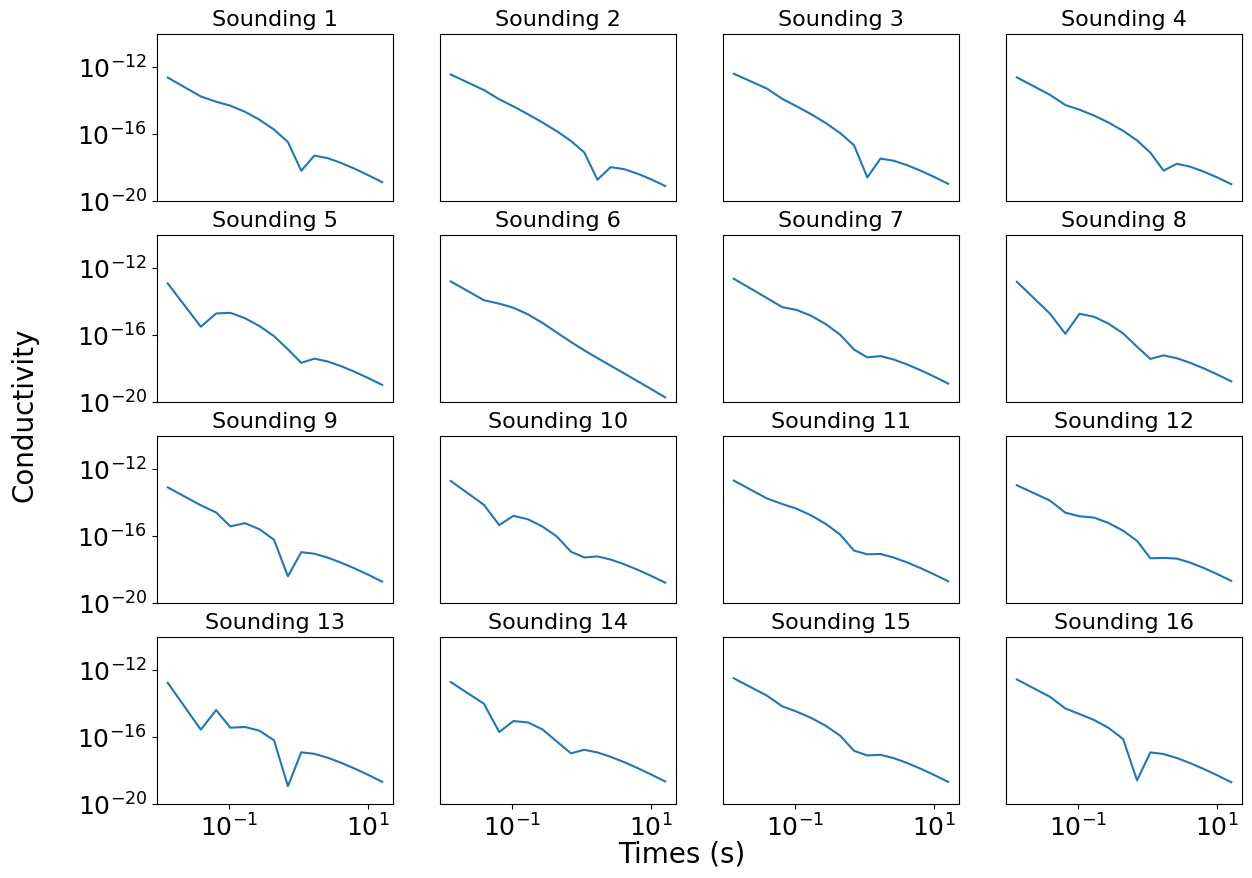

In [ ]:
network.plot_residuals(latent=zmd, ylims=(1e-20, 1e-10), weighted=False)

# Randomize latent; does data still fit?

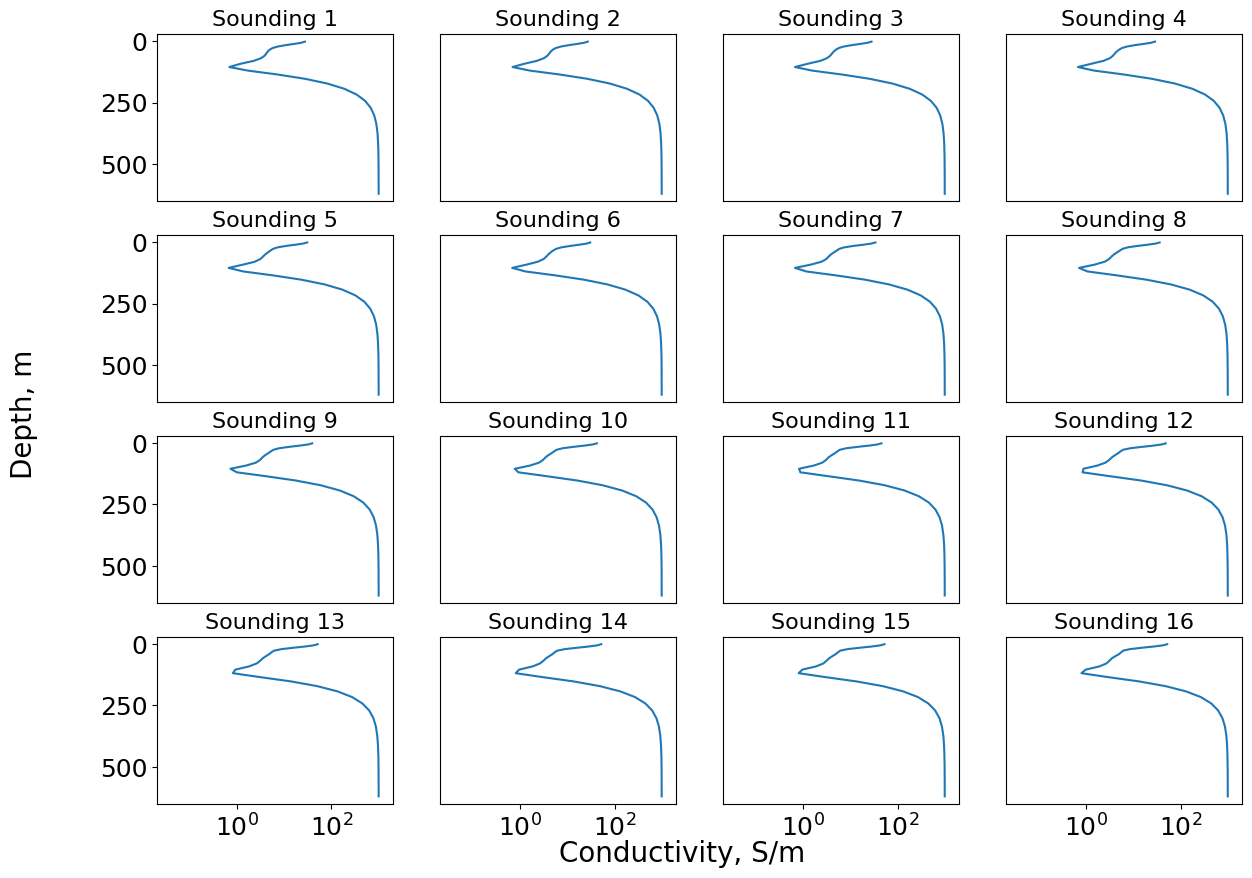

In [ ]:
vae.plot_logs(np.exp(network.tanhs_to_model(x_test1[0:16])), depths=depths)

In [ ]:
print(x_test1[0:1].shape)

(1, 32, 1)


In [ ]:
data0 = tf.tile(z_data[0:1],[16,1])
zmd2 = tf.concat((latent_input,data0),-1)

In [ ]:
network.plot_models(latent=zmd2)

In [ ]:
zmd2_tanhs = network.decode(zmd2, apply_tanh=True)
zmd2_samples = zmd2_tanhs.shape[0]
zmd2_tanhs = np.reshape(zmd2_tanhs, (zmd2_samples, network.n_model))
zmd2_logs = np.exp(network.tanhs_to_model(zmd2_tanhs))

In [ ]:
zmd2_logs.shape

(16, 32)

In [ ]:
depth_centers = (network.depths[1:] + network.depths[:-1])/2
plot_depths = np.r_[
    depth_centers[0] - (depth_centers[1] - depth_centers[0]),
    depth_centers,
    depth_centers[-1] + depth_centers[-1] - depth_centers[-2]
]

In [ ]:
# print(zmd2_logs)
mean_cond = np.mean((zmd2_logs),axis=0)
std_cond = np.std((zmd2_logs),axis=0)
mean_cond = np.delete(mean_cond, [-2,-1])
std_cond = np.delete(std_cond, [-2,-1])
uncertainty = np.mean(mean_cond+std_cond**2)
print(uncertainty)
# plt.semilogx(mean_cond, plot_depths)
# plt.invert_yaxis()

1.3077266


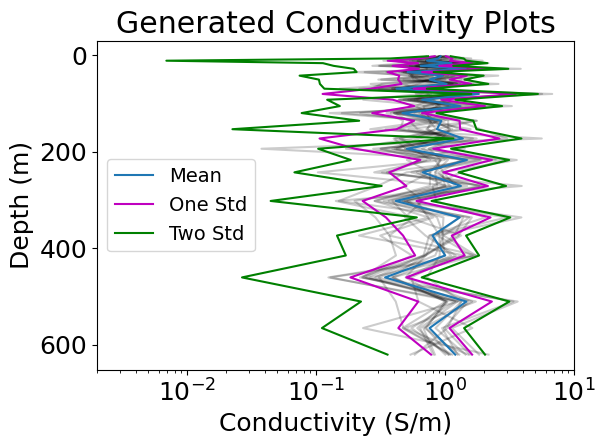

In [ ]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    if len(log) != len(plot_depths):
        log = np.delete(log, [-2,-1])
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(mean_cond+std_cond,plot_depths, c='m', label="One Std")
ax.semilogx(mean_cond-std_cond, plot_depths, c='m')
ax.semilogx(np.abs(mean_cond+2*std_cond), plot_depths, c='g', label= 'Two Std') # type: ignore
ax.semilogx(np.abs(mean_cond-2*std_cond), plot_depths, c='g')
# ax.semilogx(mean_cond+std_cond**2, plot_depths)
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(2e-3, 1e1)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots_mean&2std.jpg')
plt.show()

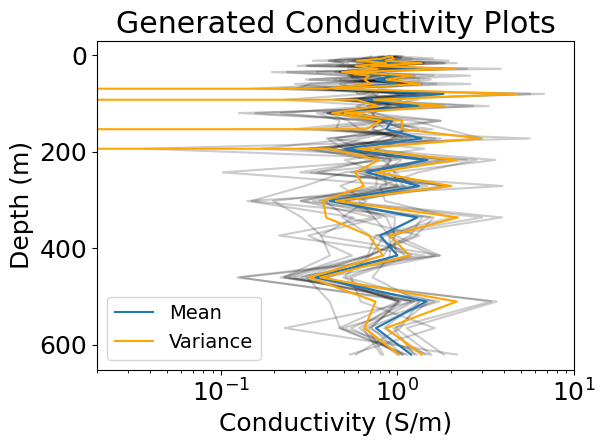

In [ ]:
fig, ax = plt.subplots()
for log in zmd2_logs:
    if len(log) != len(plot_depths):
        log = np.delete(log, [-2,-1])
    ax.semilogx(log, plot_depths, c='k', alpha=0.2)
ax.semilogx(mean_cond, plot_depths,label='Mean')
ax.semilogx(mean_cond+std_cond**2, plot_depths, c='orange', label='Variance')
ax.semilogx(mean_cond-std_cond**2, plot_depths, c='orange')
ax.invert_yaxis()
ax.axes.set_xlabel("Conductivity (S/m)")
ax.axes.set_ylabel("Depth (m)")
ax.axes.set_xlim(2e-2, 1e1)
ax.axes.set_title('Generated Conductivity Plots')
ax.axes.legend(fontsize=14)

plt.tight_layout()
plt.savefig('Preliminary_generated_plots.jpg')
plt.show()

In [ ]:
network.plot_data(latent=zmd2)

d_obs tf.Tensor(
[[-6.43978273e-12 -9.91120814e-13 -1.61147273e-13 -2.29042351e-14
  -3.58281511e-15 -7.25147394e-16 -1.96551441e-16 -5.98740591e-17
  -1.83601538e-17 -5.39755864e-18 -1.50802212e-18 -4.03053705e-19
  -1.05084695e-19 -2.36583882e-20]
 [-6.43978273e-12 -9.91120814e-13 -1.61147273e-13 -2.29042351e-14
  -3.58281511e-15 -7.25147394e-16 -1.96551441e-16 -5.98740591e-17
  -1.83601538e-17 -5.39755864e-18 -1.50802212e-18 -4.03053705e-19
  -1.05084695e-19 -2.36583882e-20]
 [-6.43978273e-12 -9.91120814e-13 -1.61147273e-13 -2.29042351e-14
  -3.58281511e-15 -7.25147394e-16 -1.96551441e-16 -5.98740591e-17
  -1.83601538e-17 -5.39755864e-18 -1.50802212e-18 -4.03053705e-19
  -1.05084695e-19 -2.36583882e-20]
 [-6.43978273e-12 -9.91120814e-13 -1.61147273e-13 -2.29042351e-14
  -3.58281511e-15 -7.25147394e-16 -1.96551441e-16 -5.98740591e-17
  -1.83601538e-17 -5.39755864e-18 -1.50802212e-18 -4.03053705e-19
  -1.05084695e-19 -2.36583882e-20]
 [-6.43978273e-12 -9.91120814e-13 -1.61147273e-13 -

In [ ]:
#log_data_test[0]

In [ ]:
-tf.exp(zmd2[0, 50:])

<tf.Tensor: shape=(0,), dtype=float32, numpy=array([], dtype=float32)>

In [ ]:
# network.predict_tanh(network.decode(zmd2, apply_tanh=True))[0]

tanhs (16, 32, 1)
ys (16, 30)
ys_test (16,)
n_data 30
d_obs tf.Tensor(
[[ 4.88531199e-13 -9.31446015e-14 -2.24994499e-14 -5.73330090e-15
  -1.45119116e-15 -4.57656984e-16 -1.79238644e-16 -8.01143151e-17
  -3.71072660e-17 -1.69046435e-17 -7.38409326e-18 -3.08356409e-18
  -1.23886251e-18 -4.86053344e-19 -1.71102142e-19 -3.98075080e-11
   6.43978273e-12  9.91120814e-13  1.61147273e-13  2.29042351e-14
   3.58281511e-15  7.25147394e-16  1.96551441e-16  5.98740591e-17
   1.83601538e-17  5.39755864e-18  1.50802212e-18  4.03053705e-19
   1.05084695e-19  2.36583882e-20]
 [ 4.88531199e-13 -9.31446015e-14 -2.24994499e-14 -5.73330090e-15
  -1.45119116e-15 -4.57656984e-16 -1.79238644e-16 -8.01143151e-17
  -3.71072660e-17 -1.69046435e-17 -7.38409326e-18 -3.08356409e-18
  -1.23886251e-18 -4.86053344e-19 -1.71102142e-19 -3.98075080e-11
   6.43978273e-12  9.91120814e-13  1.61147273e-13  2.29042351e-14
   3.58281511e-15  7.25147394e-16  1.96551441e-16  5.98740591e-17
   1.83601538e-17  5.39755864e-18  1

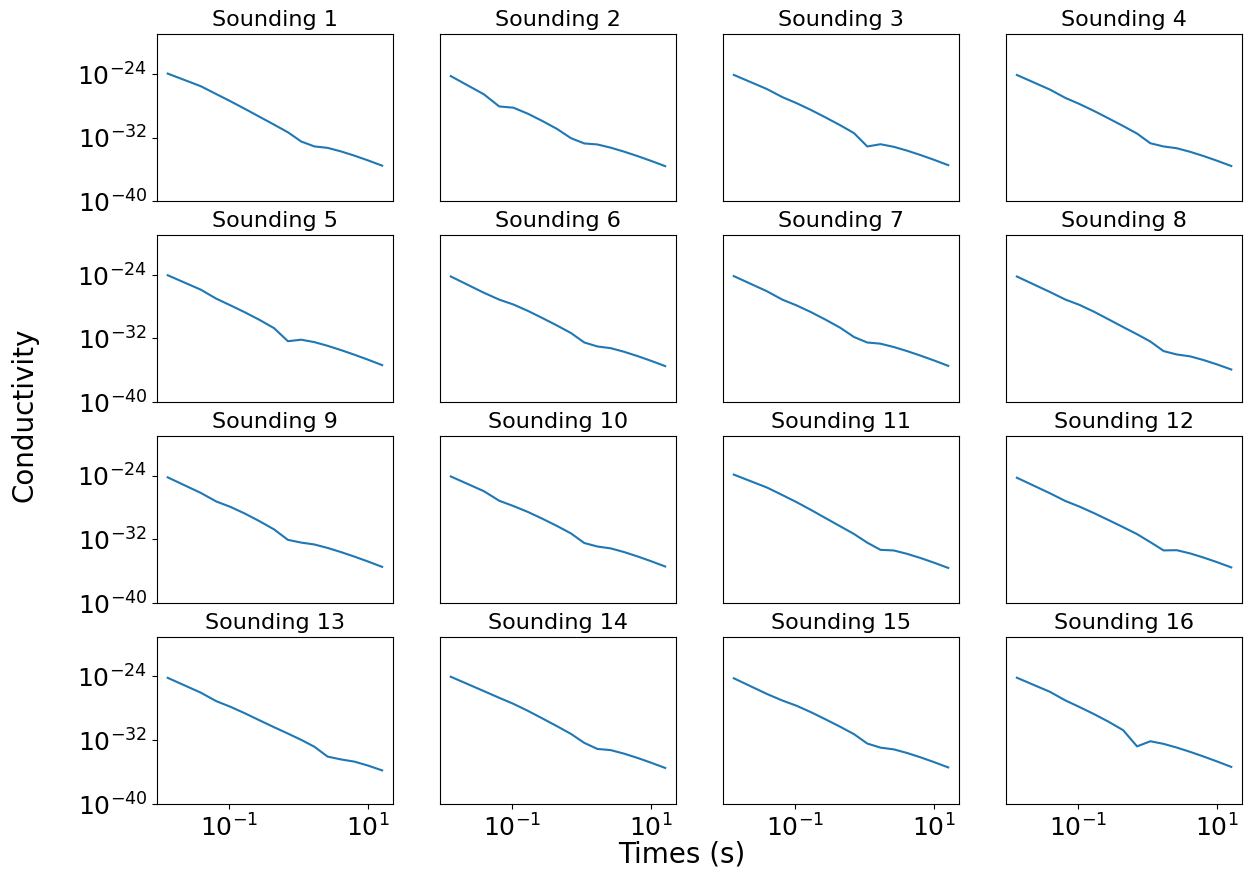

In [ ]:
network.plot_residuals(latent=zmd2, ylims=(1e-40, 1e-19), weighted=True)

In [ ]:
y_true = [[0., 0.], 
          [0., 0.]]
y_pred = [[3., 0.], 
          [2., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
# Using 'none' reduction type.
mse = tf.keras.losses.MeanSquaredError(
    reduction=tf.keras.losses.Reduction.NONE)
# Calling with 'sample_weight'.
mse(y_true, y_pred, sample_weight=[0.7, 0.3]).numpy()


array([3.1499999, 0.6      ], dtype=float32)

In [ ]:
1/2*((3-0)**2 + 0**2)*.7, 1/2*((2-0)**2 + (0-0)**2)*.3

(3.15, 0.6)

In [ ]:
network.data_weights

array([[[4.4106217e+24],
        [1.5758133e+26],
        [1.5499900e+27],
        [1.3098774e+28],
        [1.1854100e+29],
        [9.0265519e+29],
        [5.0243386e+30],
        [1.8803690e+31],
        [5.6199992e+31],
        [1.5466500e+32],
        [4.1981657e+32],
        [1.1548345e+33],
        [3.2322122e+33],
        [9.2114759e+33],
        [2.9938934e+34],
        [1.3538177e+21],
        [4.7031145e+22],
        [1.2694940e+24],
        [2.6835553e+25],
        [6.7463691e+26],
        [1.7170682e+28],
        [3.9207266e+29],
        [5.4014890e+30],
        [4.7518372e+31],
        [3.3808696e+32],
        [2.2587030e+33],
        [1.4856874e+34],
        [9.7219809e+34],
        [6.2758446e+35],
        [4.8178566e+36]]], dtype=float32)

In [ ]:
print(cond2[0])
print(cond2[1])

[3.648398e-02 4.375333e-02 6.125686e-02 9.333318e-02 1.370639e-01
 1.768252e-01 2.043877e-01 2.243076e-01 2.409013e-01 2.620672e-01
 3.102367e-01 4.454715e-01 8.480549e-01 1.465697e+00 5.938051e-01
 1.385875e-01 3.616845e-02 1.220992e-02 5.347820e-03 2.938946e-03
 1.941052e-03 1.475557e-03 1.242081e-03 1.121129e-03 1.058532e-03
 1.026996e-03 1.011817e-03 1.004928e-03 1.002029e-03 1.001002e-03]
[3.692505e-02 4.404815e-02 6.117529e-02 9.257349e-02 1.356392e-01
 1.754015e-01 2.036590e-01 2.246761e-01 2.426639e-01 2.649555e-01
 3.129994e-01 4.433329e-01 8.184385e-01 1.454583e+00 6.258761e-01
 1.456389e-01 3.750132e-02 1.251276e-02 5.433118e-03 2.967756e-03
 1.952150e-03 1.480173e-03 1.244037e-03 1.121919e-03 1.058802e-03
 1.027046e-03 1.011785e-03 1.004876e-03 1.001975e-03 1.000939e-03]


In [ ]:
# num_plots = 4
# fig = plt.figure(figsize=(8, 10))
# for i in range(0, num_plots):
#     ax = plt.subplot(int(num_plots),2,i+1)
#     ax.plot(times, -obs2[i], -pred2[i])
#     plt.xlabel('Time (s)')
#     plt.ylabel('dB/dt')
#     plt.legend(['Observed','Predicted'])
# plt.tight_layout()
# plt.savefig('Raw_Time_Decay_Curves_Line2_Central.jpg')

In [ ]:
# print(len(cond2))

In [ ]:
# depths1 = np.append(depths,[652])
# fig, ax = plt.subplots()
# ax.semilogx(cond2[0], depths1, c='k', alpha=0.2)
# ax.semilogx(cond1[0], depths1, c='k',alpha=0.2)
# ax.invert_yaxis()
# # ax.axes.set_xlim(1e-2, 1e4)
# plt.xlabel('Conductivity')
# plt.ylabel('Depth')
# plt.tight_layout()
# plt.savefig('Raw_ConductivityvsDepth_Line2_Central.jpg')
# plt.show()